<h1/> Multiset-Bert model

> ID: 2531173P


In this project, we are implementing the multi-set model based on Bert to achieve the emotion detection task with horse racing comment data set. The evaluation report functions(including confusion matrix, evaluation_summary) are inspired by Georgios.

Before start, we need to upload two files:
1. Horseracing_emotion: the data set we are going to use
2. NRCLex: the NRC Lexicon emotion data set which contains the words along with emotion identified by NRC Lexicon


## Import Library


Import all the library/module that we need.


*   pandas
*   numpy
*   sklearn
*   torch
*   transformers



In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from torch.autograd import Variable
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
!pip install transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertModel
from transformers import get_linear_schedule_with_warmup
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

     |████████████████████████████████| 3.3 MB 14.5 MB/s 
     |████████████████████████████████| 61 kB 637 kB/s 
     |████████████████████████████████| 596 kB 78.5 MB/s 
     |████████████████████████████████| 895 kB 78.2 MB/s 
     |████████████████████████████████| 3.3 MB 42.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Data Loading & Pre-processing

We load a dictionary contains the word and its emotion, which we will use to apply to our model later.

Since the dictionary contains the emotion that is not in our expectation, so we delete those emotions only remain the emotion we are going to use.

In [2]:
NRC_Lex = pd.read_csv("NRCLex.csv")
Horseracing = pd.read_csv("horseracing_emotion.csv")
exp_emotion = Horseracing.emotion.unique()
useless_emotion = []
for i in range(0, len(NRC_Lex.columns)):
  if str(NRC_Lex.columns[i]) in exp_emotion:
    continue
  else:
    useless_emotion.append(NRC_Lex.columns[i])
NRC_Lex = NRC_Lex.drop(useless_emotion, axis=1)
NRC_Lex

,Positive,Negative,Anticipation,Fear,Joy,Sadness
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,1,0,1,0,1
3,0,1,0,1,0,1
4,0,1,0,1,0,1
...,...,...,...,...,...,...
14177,0,0,0,0,0,0
14178,0,0,0,0,0,0
14179,0,0,0,0,0,0
14180,0,0,0,0,0,0


In [3]:
horseracing = pd.read_csv("horseracing_emotion.csv")

In [4]:
positive = 0
negative = 0
sadness = 0
joy = 0
anticipation = 0
fear = 0
for i in range(len(horseracing.emotion)):
  if horseracing.emotion[i] == "Positive":
    positive += 1
  elif horseracing.emotion[i] == "Negative":
    negative += 1
  elif horseracing.emotion[i] == "Sadness":
    sadness += 1
  elif horseracing.emotion[i] == "Joy":
    joy += 1
  elif horseracing.emotion[i] == "Anticipation":
    anticipation += 1
  elif horseracing.emotion[i] == "Fear":
    fear += 1

emotion_count = [positive, negative, sadness, joy, anticipation, fear]
emotion_count

[10665, 6595, 13265, 1499, 16279, 1692]

## Deal with horseracing data set
Load the horse racing comment data set, and divided it into training&testing data set.

Then tokenize each word of the data set, and form the return value to the type that we needed. So there are specific operations inside tokenize function.

In [5]:
def load_horseracing():
  '''
  Load the horseracing comment data set. Since not all the emotions are needed, we filter some emotions with little
  proportion. And divide them into training&testing data set.

  '''
  horseracing = pd.read_csv("horseracing_emotion.csv")
  word_count = 0
  for i in range(0,len(horseracing.comment)):
    if word_count >= len(str(horseracing.comment[i]).split(" ")):
      continue
    else:
      word_count = len(horseracing.comment[i].split(" "))
  exp_emotion = ["Positive", "Negative", "Sadness", "Joy", "Anticipation", "Fear"]
  horseracing_emotion_set = horseracing.emotion.unique()
  # print(wang_emotion_set)
  for i in horseracing_emotion_set:
    if i in exp_emotion:
      continue
    else:
      horseracing = horseracing[horseracing.emotion != i]
  horseracing = horseracing.drop(horseracing.columns[0], axis=1).sample(frac=1).reset_index(drop = True)
  horseracing_label_dict = {0:"Positive", 1:"Negative", 2:"Sadness", 3:"Joy", 4:"Anticipation", 5:"Fear"}

  for j in horseracing_label_dict:
    horseracing["emotion"] = horseracing["emotion"].replace(horseracing_label_dict[j],j)

  sample_size = 5000
  horseracing_pos = horseracing[horseracing.emotion == 0][:sample_size]
  horseracing_neg = horseracing[horseracing.emotion == 1][:sample_size]
  # this statement is to experiment the hypothesis: we take half of the negative emtion set to see if this affect the prediction performance of emotion fear
  # horseracing_neg = horseracing[horseracing.emotion == 1][:int(sample_size/2)]
  horseracing_sadness = horseracing[horseracing.emotion == 2][:sample_size]
  horseracing_joy = horseracing[horseracing.emotion == 3][:sample_size]
  horseracing_anticipation = horseracing[horseracing.emotion == 4][:sample_size]
  horseracing_fear = horseracing[horseracing.emotion == 5][:sample_size]
  horseracing_pos_train, horseracing_pos_test = train_test_split(horseracing[horseracing.emotion == 0][:sample_size], test_size=0.2)
  horseracing_neg_train, horseracing_neg_test = train_test_split(horseracing[horseracing.emotion == 1][:sample_size], test_size=0.2)
  horseracing_sadness_train, horseracing_sadness_test = train_test_split(horseracing[horseracing.emotion == 2][:sample_size], test_size=0.2)
  horseracing_joy_train, horseracing_joy_test = train_test_split(horseracing[horseracing.emotion == 3][:sample_size], test_size=0.2)
  horseracing_anti_train, horseracing_anti_test = train_test_split(horseracing[horseracing.emotion == 4][:sample_size], test_size=0.2)
  horseracing_fear_train, horseracing_fear_test = train_test_split(horseracing[horseracing.emotion == 5][:sample_size], test_size=0.2)
  horseracing_train_df = pd.concat([horseracing_pos_train, horseracing_neg_train, horseracing_sadness_train, horseracing_joy_train, horseracing_anti_train, horseracing_fear_train]).sample(frac=1).reset_index(drop=True)
  horseracing_test_df = pd.concat([horseracing_pos_test, horseracing_neg_test, horseracing_sadness_test, horseracing_joy_test, horseracing_anti_test, horseracing_fear_test]).sample(frac=1).reset_index(drop=True)

  horseracing_train_list = [horseracing_train_df['comment'], horseracing_train_df['emotion']]
  horseracing_test_list = [horseracing_test_df['comment'], horseracing_test_df['emotion']]

  return horseracing_train_list, horseracing_test_list, horseracing_label_dict, word_count

In [6]:
def tokenize(sentence, output, max_len=100):
  '''
  Tokenize each sentence of our data set and generate the attention matrix of our data set.

  Parameters:
    sentence: list - the data set we want to tokenize;
    output: list - the data set that contains the output of the previous data set;
    max_len: int - an integer number that gives the max length for each sentence.
  '''

  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  sentences_id = []
  attention_count = []
  sentences_ids_output = []
  attention_layer = []
  attention_layer_output = []
  label_output = []
  for i in sentence:
    sentences_id.append(tokenizer.encode(str(i), add_special_tokens=True))
  
  # pad the sequence for each sentence that is shorter than the max length
  sentences_ids = pad_sequences(sentences_id, maxlen=max_len, dtype='long', value=0, truncating='post', padding='post')

  # generate the attention matrix, that help our model to focus on the real content of our data set
  for i in sentences_ids:
    temp = []
    for j in i:
      if j == 0:
        temp.append(0)
      else:
        temp.append(1)
    attention_layer.append(temp)
  for i in attention_layer:
    attention_count.append(i.count(1))

  # For our data set, it might be meaningless to give attention on the extremely short sentences.
  # Therefore we filter the first 20% short sentences and last 20% extremely long sentences to improve our model.
  attention_index_total = np.argsort(np.array(attention_count))
  attention_index_output = attention_index_total[int(len(attention_index_total)*0.2):int(len(attention_index_total)*0.8)]
  for i in attention_index_output:
    sentences_ids_output.append(sentences_ids[i])
    attention_layer_output.append(attention_layer[i])
    label_output.append(output[i])
  return sentences_ids_output, label_output, attention_layer_output, tokenizer.get_vocab()

In [7]:
def load_dataset_function(data_load_function, batch_size, max_len):

  '''
  Main function of load the data set and turns all the data set into tensor form in order to fit the neural network.

  Parameters:
    data_load_function: - the function that use to load our data set;
    batch_size: int - the number of batch size used for model training;
    max_len: int - the max lengthe each sentence can be.
  
  '''

  train_set, test_set, labels_dict, word_count = data_load_function()

  train_input, train_output = train_set[0], train_set[1]
  test_input, test_output = test_set[0], test_set[1]

  train_input, train_output, train_masks, train_getvocab = tokenize(train_input,train_output,100)
  test_input, test_output, test_masks, test_getvocab = tokenize(test_input,test_output,100)

  # convert data set into tensor form
  train_input = torch.tensor(train_input)
  train_output = torch.tensor(train_output)
  train_masks = torch.tensor(train_masks)

  test_input = torch.tensor(test_input)
  test_output = torch.tensor(test_output)  
  test_masks = torch.tensor(test_masks)


  # create the data loader of our training\teating data set for the further training
  train_data = TensorDataset(train_input, train_masks, train_output)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  test_data = TensorDataset(test_input, test_masks, test_output)
  test_sampler = SequentialSampler(test_data)
  test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

  return train_dataloader, test_dataloader, test_output, labels_dict, train_getvocab

# Bert Model building

In [8]:
# Multiset-Bert model
# the Bert model implementation is inspired by the huggingface library
# https://huggingface.co/transformers/_modules/transformers/modeling_bert.html

class Multiset(nn.Module):
    def __init__(self, model_name, tokenizer_name, num_labels, embedding, embedding_dim, dropout_prob=0.5, bert_hidden_size=768):

      '''
      Initialize the layer of this model.

      Parameters:
        model_name: String - the supered model name used for the Bert model;
        tokenizer_name: String - the supered model name used for the tokenizer layer;
        num_labels: int - number of labels in our data set;
        embedding: Tensor - pretrained embedding layer;
        embedding_dim: int - the dimension of our embedding tensor;
        dropout_prob: float - the dropout probability;
        bert_hidden_size: int - Bert hidden dimension, for "bert-use-uncased" is usually 768.
      '''

      super().__init__()
      self.num_labels = num_labels
      self.bert = BertModel.from_pretrained(model_name)
      self.dropout = nn.Dropout(dropout_prob)
      self.classifier1 = nn.Linear(bert_hidden_size+400,num_labels)
      self.embedding = embedding
      self.embedding_dim = embedding_dim
      self.tokenizer = BertTokenizer.from_pretrained(tokenizer_name, do_lower_case=True)


    def forward(self, input_ids = None, attention_mask = None):
      '''
      Forward function that adjust the parameters in the neural network and produce the result.

      Parameters:
        input_ids: Tensor - input data set.
        attention_mask: Tensor - the attention layer corresponds to the input data set.
      '''

      outputs = self.bert(input_ids, attention_mask = attention_mask)
      embedding = self.embedding(input_ids)
      embedding = embedding.view(embedding.size(0), -1)
      pooled_output = self.dropout(torch.cat((outputs[1],embedding),1))
      outputs = self.classifier1(pooled_output)
      outputs = torch.log_softmax(outputs,1) 
      return outputs

# Training & Evaluation

## Evaluation functions
Print the evaluate report

In [9]:
def get_classes_stats(predicted_output, true_output):

  '''
    Returns the calculated evaluation metrics for each class.
    
    Parameters:
       predicted_output: {numpy.array} Predicted output.
       true_output: {numpy.array} True output.
  '''

  report_dict = classification_report(true_output, predicted_output, output_dict=True)
  classes = []
  classes_stats = []
  for key in report_dict:
      if key not in ["accuracy", "macro avg", "weighted avg"]:
        classes.append(int(float(key)))
        stats = [float("%0.3f" % (report_dict[key]['precision'])), float("%0.3f" % (report_dict[key]['recall'])), 
                  float("%0.3f" % (report_dict[key]['f1-score'])), report_dict[key]['support']]
        classes_stats.append(stats)
  return [classes, classes_stats]

def plot_confusion_matrix(description, predicted_output, true_output, labels_dict, normalize=False):

  '''
  Plots a confusion matrix for the predicted output.

  Parameters:
      description: {str} Description.
      predicted_output: {numpy.array} Predicted output.
      true_output: {numpy.array} True output.
      labels_dict: {dict} Dictionary of class labels.
      normalize: {bool} Normalize values or not.
  '''


  title = "Confusion matrix: '%s'" % (description)
  if normalize:
      title = title + " (Normalized)"
  cm = confusion_matrix(true_output, predicted_output)
  classes = get_classes_stats(predicted_output, true_output)[0]
  labels = []
  for item in classes:
      labels.append(labels_dict[item])
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig = plt.figure(figsize=(12, 12))
  ax = fig.add_subplot(1, 1, 1)
  cmap = plt.cm.Blues
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]), yticklabels=labels)
  ax.set_xticklabels(labels, rotation='vertical')
  ax.set_title(title, fontsize=20)
  ax.set_ylabel("True labels", fontsize=20)
  ax.set_xlabel("Predicted labels", fontsize=20)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
  ax.grid(False)

## Training & Evaluation function
Use to evaluate the performance of the model, and a evaluation summary.

In [10]:
def train_evaluation(model, train_dataloader, test_dataloader, test_output, scheduler, optimizer, grad_clip, training_times, verbose=False):

  '''
  Train & Evaluation function, the model will be trained and evaluated here.

  Parameters:
    model: model to be evaluated.
    train_dataloader: {Tensor} form training data set.
    test_dataloader: {Tensor} form testing data set.
    test_output: {Tensor} form output.
    optimizer: use to optimize the training process.
    scheduler: use to deal with learning rate.
    grad_clip: {boolean} used to define whether use gradient clipping or not.
    training_times: how many times the training process will go on.
    verbose: {boolean} identify verbose or not.
  '''

  if torch.cuda.is_available():    
    device = torch.device("cuda")
  else:
    device = torch.device("cpu")

  batch_count = 0
  loss_avg = []
  loss_ite = torch.nn.NLLLoss()
  label_predictions = []
  label_true = []
  predictions=[]
  predicted_output=[]

  # Training the model
  for i in range(0, training_times):
    loss_count = 0
    model.train()
    for j in train_dataloader:
      id = j[0].to(device)
      mask = j[1].to(device)
      label = j[2].to(device)

      model.zero_grad()
      model_label_output = model(input_ids = id, attention_mask = mask)
      loss = loss_ite(model_label_output, label)
      loss_count += loss.item()
      loss.backward()
      if grad_clip==True:
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      scheduler.step()
      batch_count += 1
    loss_avg.append(loss_count / batch_count)
    if verbose==True:
      print("Average loss: %0.3f" % (loss_count / batch_count))

  # After training, evaluate the model
  model.eval()
  for i in test_dataloader:
    id = i[0].to(device)
    mask = i[1].to(device)
    label = i[2].to(device)

    with torch.no_grad():
      model_output = model(input_ids = id, attention_mask = mask).detach().cpu().numpy()
    labels = label.cpu().numpy()

    label_predictions.append(model_output)
    label_true.append(label)

  for i in label_predictions:
    predictions.append(np.argmax(i,axis=1))
  for i in predictions:
    predicted_output.extend(i)

  accuracy = accuracy_score(predicted_output,test_output)
  if verbose==True:
      print("Accuracy: %0.3f" % (accuracy))
  return accuracy, predicted_output

In [11]:
def evaluation_summary(description, predicted_output, true_output, labels_dict, verbose=True):

  '''
  Returns an evaluation report for the predicted output.

  Parameters:
      description: {str} Description.
      predicted_output: {numpy.array} Predicted output.
      true_output: {numpy.array} True output.
      labels_dict: {dict} Dictionary of class labels.
      verbose: {bool} Verbose or not.
  
  '''

  precision = precision_score(true_output, predicted_output, average='weighted')
  recall = recall_score(true_output, predicted_output, average='weighted')
  accuracy = accuracy_score(true_output, predicted_output)
  f1 = fbeta_score(true_output, predicted_output, average='weighted', beta=1)
  classes = get_classes_stats(predicted_output, true_output)[0]
  classes_stats = get_classes_stats(predicted_output, true_output)[1]
  result = [[accuracy, precision, recall, f1]]
  
  if verbose:
      print("Classifier '%s':" % (description))
      print("Accuracy: %0.3f" % (accuracy))
      print("Precision (WEIGHT_AVG): %0.3f" % (precision))
      print("Recall (WEIGHT_AVG): %0.3f" % (recall))
      print("F1 (WEIGHT_AVG): %0.3f" % (f1))
  for i in range(len(classes)):
      if verbose:
          print((labels_dict[classes[i]] + " | Precision: %0.3f Recall: %0.3f F1: %0.3f Support: " + str(classes_stats[i][3])) % 
                (classes_stats[i][0], classes_stats[i][1], classes_stats[i][2]))
      result.append([labels_dict[classes[i]], classes_stats[i][0], classes_stats[i][1], classes_stats[i][2]])
  return result

## Main function to run and evaluate the model

In [12]:
def run_multiset_model(model_name, model_parameters, train_parameters, load_function, verbose=True):
  '''
  the main function contains training and testing the Bert model and print the evaluation report

  Parameters:
      model_name: {str} the name of the model
      model_parameters: {dict} Dictionary of model parameters.
      train_parameters: {dict} Dictionary of training parameters.
      load_function: {function} Function to load a dataset.
  '''


  train_dataloader, test_dataloader, test_output, labels_dict, train_getvocab = load_dataset_function(load_function, model_parameters["batch_size"], max_len = model_parameters["num_timesteps"])

  word_dic = {}
  for i in range(0, len(train_getvocab)):
    word_dic[list(train_getvocab.values())[i]] = list(train_getvocab.keys())[i]
  word_lex = np.zeros((len(train_getvocab)+1, 4))
  for i in range(0, len(train_getvocab)):
    if list(train_getvocab.keys())[i] in word_dic:
      word_lex[list(train_getvocab.values())[i]] = np.array(lex_dic[list(train_getvocab.values())[i]])
    else:
      word_lex[list(train_getvocab.values())[i]] = np.array([0.0,0.0,0.0,0.0])
  word_lex_emb = torch.from_numpy(word_lex).float()

  embedding = torch.nn.Embedding(word_lex_emb.size(0), word_lex_emb.size(1))
  embedding_dim = word_lex_emb.size(1)
    
  model = Multiset(
  "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab
  "bert-base-uncased",
  num_labels = model_parameters["num_classes"], 
  embedding = embedding,
  embedding_dim = embedding_dim,  
  dropout_prob=0.1,
  bert_hidden_size=768,
  )
  model.cuda()
  
  total_steps = len(train_dataloader) * train_parameters["num_epochs"]

  # Create the learning rate scheduler.
  optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

  scheduler = get_linear_schedule_with_warmup(optimizer, 
                          num_warmup_steps = 0, # Default value in run_glue.py
                          num_training_steps = total_steps)

  # torch.cuda.empty_cache()
  if verbose:
    print("MODEL: " + model_name)

  if verbose:
    print("TRAINING+EVALUATION:")
  post_accuracy, post_predicted_test_output = train_evaluation(model, train_dataloader, test_dataloader, test_output, scheduler, optimizer, train_parameters["gradient_clipping"], train_parameters["num_epochs"], verbose)
  
  if verbose:
      print("EVALUATION REPORT:")
  result = evaluation_summary(model_name, post_predicted_test_output, test_output, labels_dict, verbose)
  
  if verbose:
      plot_confusion_matrix(model_name, post_predicted_test_output, test_output, labels_dict)
      plot_confusion_matrix(model_name, post_predicted_test_output, test_output, labels_dict, True)

  return result

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MODEL: horseracing
TRAINING+EVALUATION:
Average loss: 1.111
Average loss: 0.404
Average loss: 0.222
Average loss: 0.139
Average loss: 0.097
Accuracy: 0.724
EVALUATION REPORT:
Classifier 'horseracing':
Accuracy: 0.724
Precision (WEIGHT_AVG): 0.728
Recall (WEIGHT_AVG): 0.724
F1 (WEIGHT_AVG): 0.724
Positive | Precision: 0.823 Recall: 0.680 F1: 0.745 Support: 622
Negative | Precision: 0.692 Recall: 0.741 F1: 0.716 Support: 410
Sadness | Precision: 0.808 Recall: 0.859 F1: 0.833 Support: 831
Joy | Precision: 0.746 Recall: 0.754 F1: 0.750 Support: 183
Anticipation | Precision: 0.583 Recall: 0.608 F1: 0.595 Support: 520
Fear | Precision: 0.545 Recall: 0.550 F1: 0.548 Support: 218


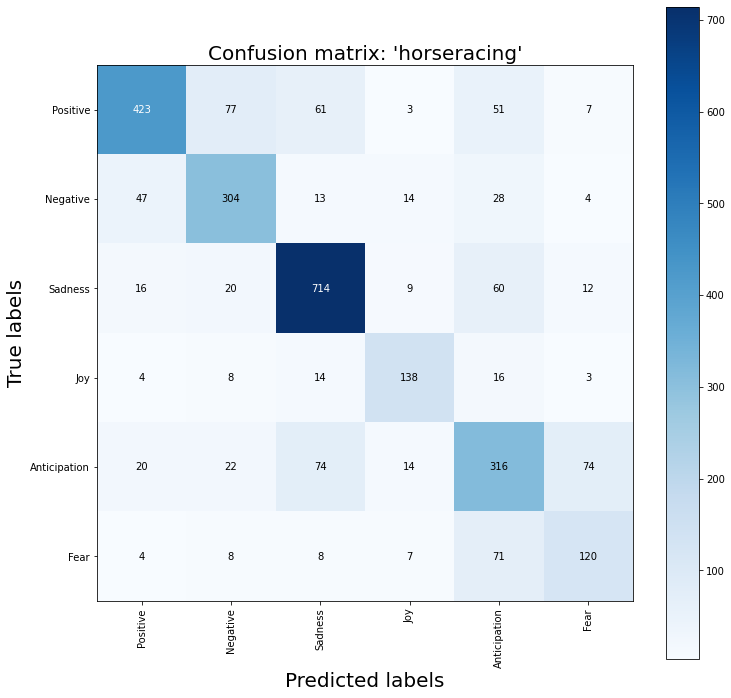

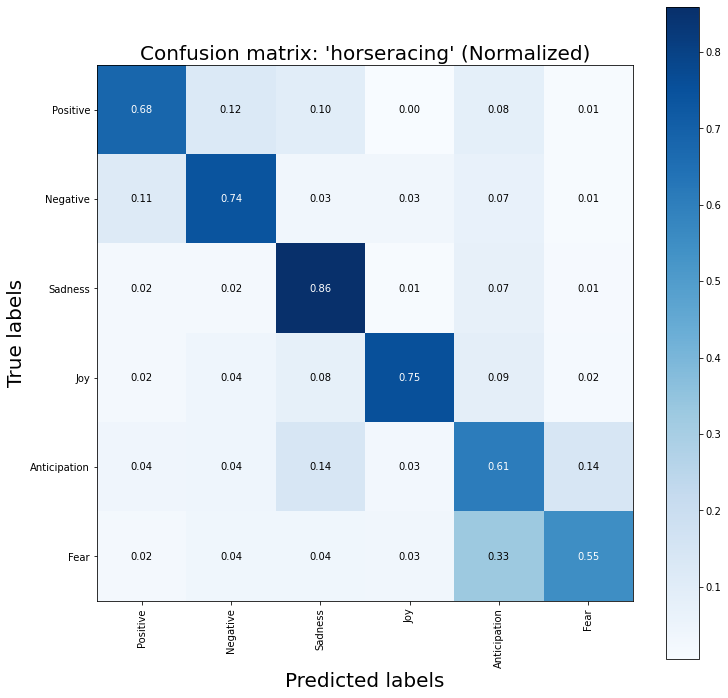

In [13]:
train_parameters = {"num_epochs": 5, "gradient_clipping": True}

model_parameters = {"batch_size": 64, "num_timesteps": 35, "num_classes": 6}

result = run_multiset_model("horseracing", model_parameters, train_parameters, load_horseracing)